# Welcome to my ML Project for Course 5510 in the CU Boulder MS-DS Program

### This file can be found in my [personal Github](https://github.com/blake-tagget/nuance-and-nonsense/tree/main/BecasueOfSchool/5010_ML_Unsupervised_Learning) 

## Project Intro

### 

## Step 1 : Gather data

In [1]:
# Step 1 - Pull some data:

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# when we upload this, ...
books_data = pd.read_csv('Books.csv')
ratings_data = pd.read_csv('Ratings.csv')
users_data = pd.read_csv('Users.csv')


print(f"""{raw_data.shape[0]} rows of  data loaded into a dataframe """)
print(f"""{raw_data.shape[1]} columns of  data loaded into a dataframe """)

8123 rows of mushroom data loaded into a dataframe 
23 columns of categorical mushroom data loaded into a dataframe 


In [2]:
# let's view the first few rows and headers of our data
raw_data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,e,e.1,s.1,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,n,g


## Step 2 : Identify an Unsupervised Machine Learning Problem

### >>> Here is the scenario: 
    
### In short: build a .

## Step 3 : Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

#### Above, we can see that the column headers need some cleaning as well as the values in the data. 



In [5]:
# let's take another look at our data with our now readable headers
raw_data.head()

,attribute,cap_shape,cap_surface,cap_color,has_bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,n,g


In [6]:
# We also see that the stalk_root feature has "?" in place of missing values. Per the data docs there are ~2k of these. 
# We should still have enough data if we remove these rows


# we will also drop any rows with missing data
initial_data = raw_data[raw_data['stalk_root']!="?"].dropna()

In [7]:
print(f"""{len(initial_data)} rows of mushroom data loaded remain. """)


5643 rows of mushroom data loaded remain. 


In [8]:
initial_data.dtypes

attribute                   category
cap_shape                   category
cap_surface                 category
cap_color                   category
has_bruises                 category
odor                        category
gill_attachment             category
gill_spacing                category
gill_size                   category
gill_color                  category
stalk_shape                 category
stalk_root                  category
stalk_surface_above_ring    category
stalk_surface_below_ring    category
stalk_color_above_ring      category
stalk_color_below_ring      category
veil_type                   category
veil_color                  category
ring_number                 category
ring_type                   category
spore_print_color           category
population                  category
habitat                     category
dtype: object

#### Great! Our final data cleaning step is to transform our table of string categorical variables into something more computationally consumable - numbers. 

To do this, we will utilize a methodology called "One Hot Encoding." Conveniently, there is a sklearn function for this exact purpose. 

Note: Because our features do not have order, we cannot use orinal encoding.

## Cleaning Conclusions

### Because the data is 100% categorical variables / features, we needed to perform a One-Hot encoding to convert the string data into numeric represented boolean data. We were able to do this with the help of an sklearn package and we can now begin to vizualize. 

### Also - due to the nature of 100% categorical data, our previously condensed dataset is now pretty sparse in nature (but has been converted technically).

#### Now that the data is cleaned, we should split it BEFORE we start to vizualize and play around with explanation. 

In [13]:
from sklearn.model_selection import train_test_split

# let's keep the standard 20% as our testing data
train_df, test_df = train_test_split(reduced_transformed_df, test_size=0.25)


### Let's vizualize what we have so far. Starting with a correlation matrix

<AxesSubplot:>

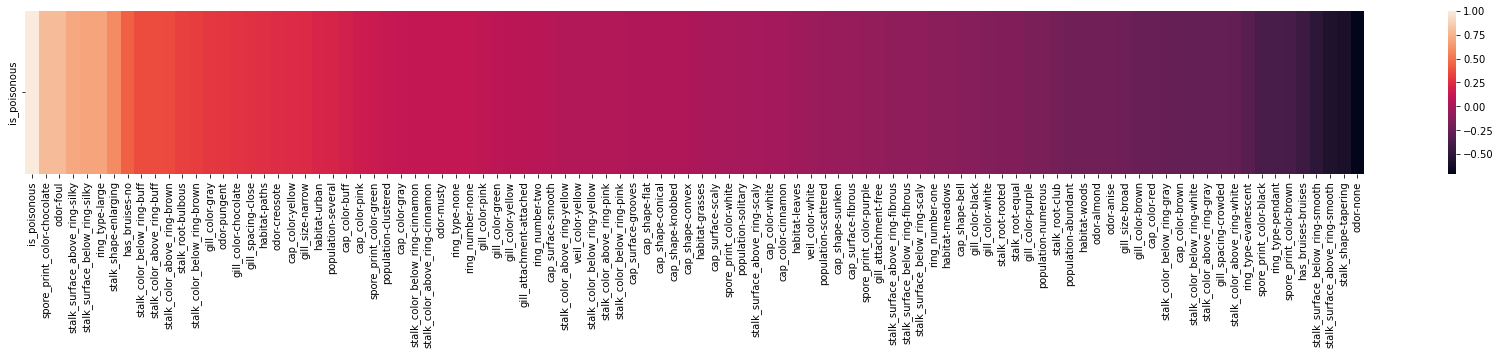

In [14]:
# let's calc the correlation and only show those features with a correlation
# Since there are so many features, i've sorted them based on their correlation to our target variable.
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (30,3)
sns.heatmap(train_df.corr().sort_values(by=['is_poisonous'],ascending=False)[['is_poisonous']].dropna().T)

In [15]:
# top 10 correlated features to the target variable
train_df.corr()['is_poisonous'].sort_values(ascending=False).head(10)

is_poisonous                      1.000000
spore_print_color-chocolate       0.790737
odor-foul                         0.790737
stalk_surface_above_ring-silky    0.705530
stalk_surface_below_ring-silky    0.691373
ring_type-large                   0.691373
stalk_shape-enlarging             0.592535
has_bruises-no                    0.432339
stalk_color_below_ring-buff       0.366028
stalk_color_above_ring-buff       0.359693
Name: is_poisonous, dtype: float64

In [16]:
# it's interesting that there are so many features with no calculatable correlation to the target variable
train_df.corr()['is_poisonous'].sort_values(ascending=False).tail(30)

odor-none                       -0.708256
cap_color-green                       NaN
cap_color-purple                      NaN
odor-fishy                            NaN
odor-spicy                            NaN
gill_attachment-descending            NaN
gill_attachment-notched               NaN
gill_spacing-distant                  NaN
gill_color-buff                       NaN
gill_color-orange                     NaN
gill_color-red                        NaN
stalk_root-cup                        NaN
stalk_root-rhizomorphs                NaN
stalk_root-missing                    NaN
stalk_color_above_ring-orange         NaN
stalk_color_above_ring-red            NaN
stalk_color_below_ring-orange         NaN
stalk_color_below_ring-red            NaN
veil_type-partial                     NaN
veil_type-universal                   NaN
veil_color-brown                      NaN
veil_color-orange                     NaN
ring_type-cobwebby                    NaN
ring_type-flaring                 

### Wonderful, a heatmap of the correlation to our target variable (poisonous prediction)! 

Things I see: 
1. Odor = Foul : the highest correlation with poisonous mushrooms -->> this is great to know as it'll provide a simple smell test!
2. Staulk Surface = Silky : the second two highest correlations again make things simple -->> avoid the silky staulks!! 
3. When we look at the negative or null correlations, we get an image of what makes an edible mushroom. 

#### But let's do one more population related vizualizations so we can make sure our split worked.

<AxesSubplot:ylabel='Frequency'>

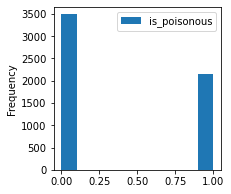

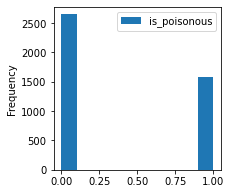

In [17]:
# now let's take our categories and look at historgrams of how they show up in our data:

reduced_transformed_df.plot.hist(column=["is_poisonous"], figsize=(3, 3))
train_df.plot.hist(column=["is_poisonous"], figsize=(3, 3))

#### In the previous 2 plots, we can see that our population percentage is maintained when splitting our data.

## Exporatory Conclusions

Since our data is all categorical, the vizualizations we can make are pretty limited since all our data are 0 and 1s.

Based on correlation only, we may be able to make some guesses as to weather a mushroom is poisonous or edible. 

# Step 4 : Perform Analysis Using Supervised Machine Learning Models

In [18]:
# first here we will need to split our X and y : 
x_train = train_df.drop(columns=['is_poisonous'])
y_train = train_df[['is_poisonous']]
x_test = test_df.drop(columns=['is_poisonous'])
y_test = test_df[['is_poisonous']]

## Model Conclusion:

### And here we are, all of our basic tree models seem to do the trick! So this is good; if we can find enough mushrooms to eat we should be 100% confident that we won't poison ourselves by using any of these models. 
Since this score is already as high as we can hope, we do not need to tune it. 



# Step 5 : Results & Analysis - Feature Importances

Below we will look each of our perfect 3 tree models and see if they have similar important features.

## Importance Conclusions

### Well, I'm not sure what to make of this. There don't seem to be many consistent top ten features between the models. Since i've run this file multiple times, at one point I would have recommended that you don't eat foul smelling mushrooms!

This tells me that there is either :
1. possibly a combination of features (interactions) that are impacting the result 
2. it is possible that multicollinearity exists. We know that multicolinearity has no impact on the score but can impact feature performance.

# Step 6 : Discussion / Overall Conclusion

#### Learning and takeaways :

Mushrooms are pretty complicated. It doesn't seem straight forward to classify a mushroom as edible or not. a google search says that less than 3% of mushrooms are poisonous, but this data suggests that ~40 % of them are.

### What didn’t work :

I believe the takeway above accurately represents what didn;t work here. Our data set has way too many poisonous samples when compared to mushrooms found in the wild. This is likely due to the fact that the mushroom species were limited in the data set.

#### Ways to improve : 

In a future iteration of this, I could imagine removing as many features as possible to get a list of what makes a mushroom poisonous or edible. I could imagine a nice field guide or info graphic with the essential features.